In [1]:
## Imports

import csv
import os
import time
from datetime import timezone, datetime

import matplotlib.pyplot as plt
import pandas as pd
import requests

In [2]:
# constant definitions
API_KEY = os.getenv('TORN_API_KEY_ENV')
SCORES_FILE_NAME = "output.csv"
SCORES_FILE_NAME_FORMATTED = "output_formatted.csv"
MASTER_FILE_NAME = "all_attacks.csv"
ASSISTS_KEY = 'rw_assist'
ATTACKS_KEY = 'rw_attacks'
OUTSIDE_ATTACKS_KEY = 'outside_attacks'
RESULT_LOST_KEY = 'total_lost'
NAME_KEY = 'player'
BONUS_RESPECT_KEY = 'bonus_hit_respect'
POINTS_LOST = 'points_lost'
POINTS_GAINED = 'points_gained'
PAYOUT_KEY = 'payout'


CODE = 'code'
TIMESTAMP_STARTED = 'timestamp_started'
TIMESTAMP_ENDED = 'timestamp_ended'
ATTACKER_ID = 'attacker_id'
ATTACKER_NAME = 'attacker_name'
ATTACKER_FACTION = 'attacker_faction'
ATTACKER_FACTIONNAME = 'attacker_factionname'
DEFENDER_ID = 'defender_id'
DEFENDER_NAME = 'defender_name'
DEFENDER_FACTION = 'defender_faction'
DEFENDER_FACTIONNAME = 'defender_factionname'
RESULT = 'result'
STEALTHED = 'stealthed'
RESPECT = 'respect'
CHAIN = 'chain'
RAID = 'raid'
RANKED_WAR = 'ranked_war'
RESPECT_GAIN = 'respect_gain'
RESPECT_LOSS = 'respect_loss'
MODIFIERS_FAIR_FIGHT = 'modifiers_fair_fight'
MODIFIERS_WAR = 'modifiers_war'
MODIFIERS_RETALIATION = 'modifiers_retaliation'
MODIFIERS_GROUP_ATTACK = 'modifiers_group_attack'
MODIFIERS_OVERSEAS = 'modifiers_overseas'
MODIFIERS_CHAIN_BONUS = 'modifiers_chain_bonus'

extra_calls = [',applications', ',armor', ',armorynews', ',attacknews',
               ',basic', ',boosters', ',cesium', ',chain', ',chainreport',
               ',chains', ',contributors', ',crimenews', ',crimes',
               ',currency', ',donations', ',drugs', ',fundsnews',
               ',mainnews', ',medical', ',membershipnews', ',positions',
               ',reports', ',revives', ',revivesfull', ',stats', ',temporary',
               ',territory', ',territorynews', ',timestamp', ',upgrades', ',weapons '
               ]


In [3]:
def csv_to_json(csv_filename):
    # Read the CSV file and store the data in a list of dictionaries
    with open(csv_filename, "r", newline="") as csvfile:
        csv_reader = csv.DictReader(csvfile)
        data = [row for row in csv_reader]
    return data


def json_to_csv(json_list, csv_filename, sort_by=None, format_attribute=None, formatter=None):
    # Get headers from the first dictionary in the list
    headers = list(json_list[0].keys())

    should_format = False
    format_index = -1
    if format_attribute and formatter:
        should_format = True
        for index, header in enumerate(headers):
            if header == format_attribute:
                format_index = index

    # Sort the list by the given column
    if sort_by is not None:
        if sort_by in headers:
            json_list.sort(key=lambda x: x[sort_by], reverse=True)
        else:
            print(f"Column '{sort_by}' not found. Saving without sorting.")

    # Open a CSV file for writing
    with open(csv_filename, "w", newline="") as csvfile:
        # Create a CSV writer object
        csv_writer = csv.writer(csvfile)

        # Write the header row
        csv_writer.writerow(headers)

        # Write the data rows
        for record in json_list:
            row = list(record.values())
            # formatter
            if should_format:
                formatted_row = row
                formatted_row[format_index] = formatter(formatted_row[format_index])
                row = formatted_row

            csv_writer.writerow(row)
    print(f"File with name {csv_filename} saved.")

In [4]:

def get_start_time_end_time(text):
    # Extract start and end times
    start_str, end_str = text.strip().split(" until ")
    start_time = datetime.strptime(start_str, "%H:%M:%S - %d/%m/%y")
    end_time = datetime.strptime(end_str, "%H:%M:%S - %d/%m/%y")

    # Convert start and end times to epoch time
    start_time_epoch = int(start_time.timestamp())
    end_time_epoch = int(end_time.timestamp())
    return {start_time_epoch, end_time_epoch}


def is_ranked_war_attack(attack_obj):
    return eval(attack_obj[RANKED_WAR]) == 1


def get_timestamp(start_day, start_hour, start_min, month, year):
    return int(datetime(year, month, start_day, start_hour, start_min, tzinfo=timezone.utc).timestamp())


def flatten_json(json_record, separator='_', prefix=''):
    flattened_record = {}

    for key, value in json_record.items():
        if isinstance(value, dict):
            flattened_sub_record = flatten_json(value, separator, prefix=f"{prefix}{key}{separator}")
            flattened_record.update(flattened_sub_record)
        else:
            flattened_record[f"{prefix}{key}"] = value

    return flattened_record


def format_payout(num):
    if num >= 100_000_000:
        return f"{num / 1_000_000:.0f}M"
    elif num >= 1_000_000:
        return f"{num / 1_000_000:.1f}M" if num % 1000000 != 0 else f"{num // 1000000}M"
    elif num >= 100_000:
        return f"{num / 1000:.0f}k"
    else:
        return str(num)


# LOAD THE LIST OF ATTACKS
def load_list():
    try:
        with open(MASTER_FILE_NAME, "r"):
            print("loaded from previously cached file")
            return csv_to_json(MASTER_FILE_NAME)
    except FileNotFoundError:
        print("all_attacks.csv not found")
        return None

In [5]:
# Process oayout
def process_payout(scores, budget):
    # Calculate the total number of weighted actions
    total_weighted_actions = sum(
        player[ATTACKS_KEY] * ATTACKS_WEIGHT +
        player[ASSISTS_KEY] * ASSISTS_WEIGHT +
        player[OUTSIDE_ATTACKS_KEY] * OUTSIDE_ATTACKS_WEIGHT
        for player in scores
    )

    # Calculate the payout for each player based on the weighted values
    for player in scores:
        weighted_actions = (
                player[ATTACKS_KEY] * ATTACKS_WEIGHT +
                player[ASSISTS_KEY] * ASSISTS_WEIGHT +
                player[OUTSIDE_ATTACKS_KEY] * OUTSIDE_ATTACKS_WEIGHT
        )
        # update the payout
        player[PAYOUT_KEY] = round(budget / total_weighted_actions * weighted_actions)
        # round off the decimals
        player[POINTS_GAINED] = round(player[POINTS_GAINED])
        player[POINTS_LOST] = round(player[POINTS_LOST])

    total_paid = sum(player[PAYOUT_KEY] for player in scores)
    print(f"total paid : {format_payout(total_paid)}")



In [6]:

# get a new record
def get_new_score_row(player_name):
    return {NAME_KEY: player_name, ATTACKS_KEY: 0, OUTSIDE_ATTACKS_KEY: 0,
            POINTS_GAINED: 0, POINTS_LOST: 0, ASSISTS_KEY: 0, BONUS_RESPECT_KEY: 0, RESULT_LOST_KEY: 0}


# All possible values of result
# draw => Stalemate
# loss => Lost, Timeout, Interrupted, Escape
# win => Attacked, Hospitalized, Assist, Mugged, Arrested
def is_win(result):
    return result in ['Attacked', 'Hospitalized', 'Stalemate', 'Mugged', 'Arrested']


def is_assist(result):
    return result == 'Assist'


def is_loss(result):
    return result in ['Lost', 'Timeout', 'Interrupted', 'Escape']


# PROCESS THE ATTACK ROWS
def process_attacks(hero_faction_name, enemy_faction_name, master_list):
    print(f"going to process total {len(master_list)} records.")

    count = 0
    outgoing = 0
    incoming = 0

    scores = {}

    for attack_obj in master_list:
        count += 1
        _id = attack_obj[CODE]
        # debug
        if _id == "debug_code":
            print("*****")
        is_rw_attack = is_ranked_war_attack(attack_obj)
        attacker_fac_name = attack_obj[ATTACKER_FACTIONNAME]
        defender_fac_name = attack_obj[DEFENDER_FACTIONNAME]
        attacker_name = attack_obj[ATTACKER_NAME]
        defender_name = attack_obj[DEFENDER_NAME]

        result = attack_obj[RESULT]

        # print(f"count: {count} id: {_id},  attacking fac : {attacker_fac_name}, defending fac : {defender_fac_name}, "
        #       f"is_rw_attack : {is_rw_attack}")

        # outside hits
        if attacker_fac_name == hero_faction_name and defender_fac_name != enemy_faction_name:
            outgoing += 1
            # create a new record if not encountered before
            attacker_id = attack_obj[ATTACKER_ID]

            # create entry if not exists
            if attacker_id not in scores.keys():
                # print(f"id: {_id} registered as outside hit")
                scores[attacker_id] = get_new_score_row(attacker_name)

            attacker_row = scores[attacker_id]
            # update existing record
            attacker_row[OUTSIDE_ATTACKS_KEY] += 1
            # record loses
            if is_loss(result):
                attacker_row[RESULT_LOST_KEY] += 1
            continue

        # hero attacked enemy - assists do not show up as is_rw_attack
        if defender_fac_name == enemy_faction_name:
            outgoing += 1
            # create a new record if not encountered before
            if attack_obj[ATTACKER_ID] not in scores.keys():
                # print(f"id: {_id} registered as rw attack")
                scores[attack_obj[ATTACKER_ID]] = get_new_score_row(attacker_name)

            attacker_row = scores[attack_obj[ATTACKER_ID]]
            # record result
            if is_assist(result):
                attacker_row[ASSISTS_KEY] += 1
            # not recording loses against RW target for now
            # elif is_loss(result):
            #   attacker_row[RESULT_LOST_KEY] += 1
            else:
                # anything else is a win
                attacker_row[ATTACKS_KEY] += 1

            # points gained
            if eval(attack_obj[MODIFIERS_CHAIN_BONUS]) < 10:
                attacker_row[POINTS_GAINED] += eval(attack_obj[RESPECT])
            # count bonuses separately
            else:
                attacker_row[BONUS_RESPECT_KEY] += eval(attack_obj[RESPECT])
            continue

        # enemy attacked hero
        if defender_fac_name == hero_faction_name and is_rw_attack:
            # create a new record if not encountered before
            if attack_obj[DEFENDER_ID] not in scores.keys():
                # print(f"id: {_id} registered as rw defend")
                scores[attack_obj[DEFENDER_ID]] = get_new_score_row(defender_name)
            # update existing record
            if eval(attack_obj[MODIFIERS_CHAIN_BONUS]) < 10:
                defender_row = scores[attack_obj[DEFENDER_ID]]
                defender_row[POINTS_LOST] += eval(attack_obj[RESPECT])
                incoming += 1
                continue

    print(f'Total hits made: {outgoing}')
    print(f'Total hits received: {incoming}')

    output = []
    for player_id in scores:
        output.append(scores[player_id])

    return output


In [7]:

# CALL API TO LOAD ATTACKS
def fetch_attacks(end_stamp, start_stamp, api_key):
    attacks_master_list = []
    next_call_stamp = start_stamp
    processed_attack_records = []
    count = 0
    print('fetching attacks using API ...')

    while next_call_stamp <= end_stamp:
        count += 1
        time.sleep(2)
        # print(f'{next_call_stamp}')
        request = requests.get(
            f'https://api.torn.com/faction/?selections=attacks'
            f'{extra_calls[count % len(extra_calls)]}&from={next_call_stamp}&key={api_key}')

        response_body = request.json()
        # attack object found
        try:
            attacks_list = response_body[ATTACKS_KEY]

            for attack_id in attacks_list:
                # update timestamp to set the next 'from' field in the API call
                attack_obj = attacks_list[attack_id]
                if attack_obj[TIMESTAMP_STARTED] > next_call_stamp:
                    next_call_stamp = attack_obj[TIMESTAMP_STARTED] - 1

                if attack_id not in processed_attack_records:
                    processed_attack_records.append(attack_id)
                    # is_rw_attack = is_ranked_war_attack(attack_id, attacks_list)
                    # prepare a master list of all attacks
                    attacks_master_list.append(flatten_json(attack_obj))

        except KeyError:
            print("No more attacks left to process")
            break
    print(f'Total API calls made -> {count}')
    return attacks_master_list

In [8]:

# GENERATE THE REPORT
def generate_report(hero_faction_name, enemy_faction_name, duration_txt, budget, api_key):
    if api_key is not None:
        masked_api_key = "*****" + api_key[-5:]
        print("Using API Key:", masked_api_key)
    else:
        print("API Key not defined.")

    start_stamp, end_stamp = get_start_time_end_time(duration_txt)
    print(f"start_stamp:{start_stamp} - end_stamp:{end_stamp}")
    # step 1 - call torn api and get a list of all the attacks & received during the RW period OR load from
    # previously written file
    attacks_master_list = load_list()
    if attacks_master_list is None:
        attacks_master_list = fetch_attacks(end_stamp, start_stamp, api_key)
        json_to_csv(attacks_master_list, MASTER_FILE_NAME)
    # step 2 - process attacks
    scores = process_attacks(hero_faction_name, enemy_faction_name, attacks_master_list)
    # step 3 - process payouts
    process_payout(scores, budget)
    json_to_csv(scores, SCORES_FILE_NAME, sort_by=PAYOUT_KEY)
    json_to_csv(scores, SCORES_FILE_NAME_FORMATTED, sort_by=PAYOUT_KEY, format_attribute=PAYOUT_KEY,
                formatter=format_payout)



In [9]:

# Visualizations

def table_scores(df):
    # Plot the table
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.axis('off')
    ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')
    plt.show()


def graph_top10(df):
    # Get the top 10 players by points gained
    top10 = df.sort_values(by=POINTS_GAINED, ascending=False).head(10)

    # Get names and points gained values
    names = top10[NAME_KEY]
    points_gained = top10[POINTS_GAINED]

    # Create the bar graph
    plt.figure(figsize=(12, 6))
    plt.bar(names, points_gained, width=0.5)
    plt.xticks(rotation=90)
    plt.xlabel('Name')
    plt.ylabel('Points Gained')
    plt.title('Top 10 Players by Points Gained')


def bleeders_graph(_df):
    # Sort the dataframe by the "attacks" column
    df = _df.sort_values(by=ATTACKS_KEY, ascending=False)

    # Get the bleeders
    bleeders = df[df[POINTS_LOST] > df[POINTS_GAINED]].sort_values(by=POINTS_LOST, ascending=False)

    # Get names and lost values
    names = bleeders[NAME_KEY]
    lost = bleeders[POINTS_LOST]

    # Create the bar graph
    plt.figure(figsize=(12, 6))
    plt.bar(names, lost, width=0.5)
    plt.xticks(rotation=90)
    plt.xlabel('Name')
    plt.ylabel('Points Lost')
    plt.title('Bleeders')

    plt.show()

Using API Key: *****UyVgD
start_stamp:1682074800 - end_stamp:1682156355
loaded from previously cached file
going to process total 2267 records.
Total hits made: 832
Total hits received: 1288
total paid : 1700M
File with name output.csv saved.
File with name output_formatted.csv saved.


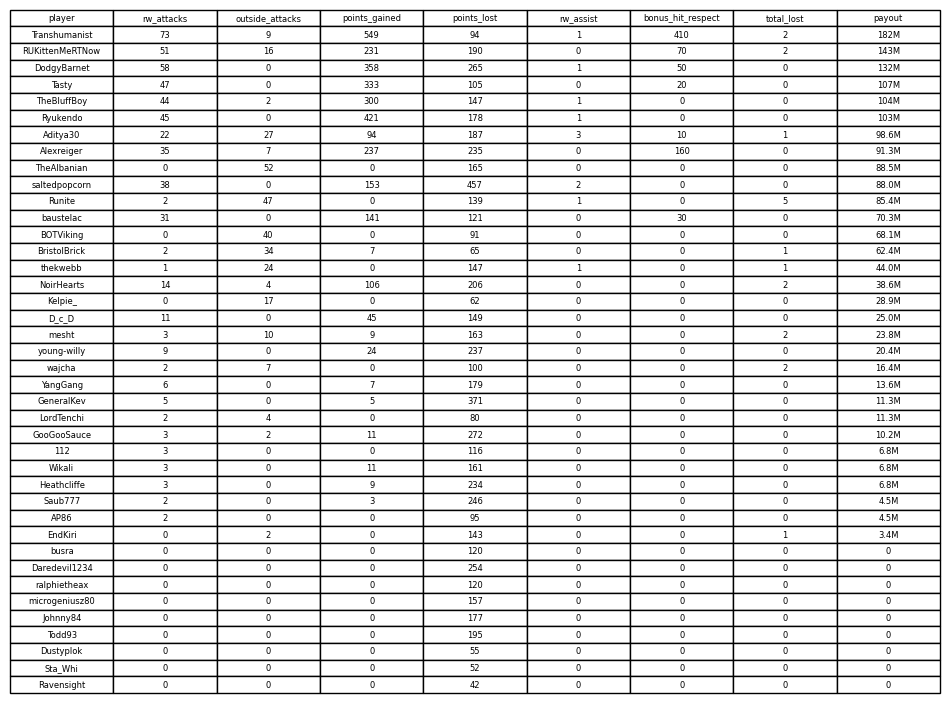

In [10]:

# weights of the hit according to hit type

ATTACKS_WEIGHT = 1.0
ASSISTS_WEIGHT = 0.4
OUTSIDE_ATTACKS_WEIGHT = 0.75

generate_report(
    hero_faction_name="The Power Rangers",
    enemy_faction_name="Revolutionary Guerrillas",
    duration_txt="15:00:00 - 21/04/23 until 13:39:15 - 22/04/23",
    budget=1_700_000_000,
    api_key=API_KEY)

# Create a dataframe from the data
# raw_data = pd.read_csv(SCORES_FILE_NAME)

table_scores(pd.read_csv(SCORES_FILE_NAME_FORMATTED))
# graph_top10(data)
# bleeders_graph(data)
